## 'Machine Learning and Statistics' module project, ATU<br>Semester 2, 2022<br>Lecturer: Ian McLoughlin

## Task: Time Series Anomaly detection using Keras

## Contents
1. [Introduction](#Introduction)
2. [What is a Time Series?](#What-is-a-Time-Series?)
3. [Analysis of Time Series](#Analysis-of-Time-Series)
4. [What is anomaly detection?](#What-is-anomaly-detection?)
5. [Types of time series anomalies](#Types-of-time-series-anomalies)<br>
    i. [Point anomalies (global outliers)](#Point-anomalies-(global-outliers))<br>
    ii. [Collective anomalies](#Collective-anomalies)<br>
    iii. [Contextual anomalies](#Contextual-anomalies)<br>
6. [Keras setup](#Keras-setup)
7. [Visualise the data](#Visualise-the-data)<br>
    i. [Timeseries data without anomalies](#Timeseries-data-without-anomalies)<br>
    ii. [Timeseries data with anomalies](#Timeseries-data-with-anomalies)<br>
8. [Prepare the training data](#Prepare-the-training-data)<br>
    i. [Create sequences](#Create-sequences)<br>
9. [Build a model](#Build-a-model)
10. [Train the model](#Train-the-model)<br>
    i. [Training and validation loss](#Training-and-validation-loss)<br>
11. [Anomaly detection](#Anomaly-detection)

## Introduction
From the Keras website, use the example [Timeseries anomaly detection using an Autoencoder](https://keras.io/examples/timeseries/timeseries_anomaly_detection/).<br>
<br>
Re-create the example and explain the concepts in more detail.<br>
By the end of this notebook, the reader should have an understanding of what Keras does,<br>
and what it can be used for.<br>


## What is a Time Series?
A time series is a series of data points that are indexed in time order.<br>
Examples of time series are heights of ocean tides, stock market prices, house prices and many more where the index is either increasing or decreasing over time.

Time series is a data set plotted against time; that's where the term comes from.

## Analysis of Time Series
Time series data is analysed in order to extract insight from it; for example, time series forecasting tries to predict future values based on previously recorded values by using a mathematical model.<br>
From this, patterns or trends in the data might emerge that could provide insight into future behaviour of the data, i.e. cyclical or seasonal patterns.

Time series analysis of a business' data can identify trends in historical data that might be explained by processes or methods and thus future behaviour and/or patterns can be predicted.

## What is anomaly detection?

If time series data is used to forecast future behaviour, then an anomaly would be any event that lies outside the range of the expected future behaviour. 

Anomaly detection is a step in machine learning that identifies whether:
- data points
- events
- observations
that is outside the range of expected behaviour for a data set. 
Examples can include servers failing, a change in consumer behaviour, or cyberattacks. 
<br>

An anomaly is also known as an outlier.

## Types of time series anomalies

### Point anomalies (global outliers)

This is when a datapoint falls outside the expected range or pattern of the dataset.<br>
An example would be financial spending - using debit card spending as an example, the normal pattern of spending would be small to medium sized amounts, located in a particular geographical area (let's say Ireland in this case).
A point anomaly would be a large sized amount that originated in a different country - it's outside the normal geographical region and over the amount that is usually spent.

### Collective anomalies

This is when a datapoint falls within the expected range or pattern of the dataset, but when examined as a group of datapoints, unexpected patterns present themselves.<br>
Using the debit card spending as an example, we can say that the holder of the card lives and makes most of their purchases with the debit card in and around County Cork.
However, there could also be purchases that are small to medium sized in Galway - perhaps on the same day within a few minutes of each other, which would indicate a cloned card.

### Contextual anomalies
This is when datapoints are considered anomalies when considered within the context of the dataset.
Using network traffic as an example - we would expect the majority of network traffic to be during business hours, so if there's a large amount of traffic suddenly in the middle of the night, it could be a Denial-Of-Service (DOS) attack or a network intrusion attempt.

## Keras setup

In [30]:
# Numerical arrays
import numpy as np
# Spreadsheet-type data - data frames
import pandas as pd

# Import Keras - for working with neural networks
from tensorflow import keras
from tensorflow.keras import layers

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns

### Using a reconstruction convolutional autoencoder model to detect anomalies in timeseries data

### Autoencoder definition

An autoencoder is a [type of neural network](https://www.tensorflow.org/tutorials/generative/autoencoder) that is trained to copy its input to its output.<br>
It learns to compress the data while minimizing the reconstruction error.<br>

An autoencoder works via the following:<br>
- Compresses and encodes the input data (training).
- Learns how to reconstruct (decode) the data from the encoded form, producing an output as close to the original as possible.
- Tests against input data (training data)

Another way of describing the above is to say that the autoencoder *trains* on input data, *tests* what it has produced and then the output is *validated* against the input.

The first step is to load the [Numenta Anomaly Benchmark (NAB)](https://www.kaggle.com/boltzmannbrain/nab) dataset.<br>
This dataset provides artificial timeseries data containing labeled anomalous periods of behaviour.

Datapoints are:
- ordered
- timestamped
- single-valued

As in the Keras documentation page:
- art_daily_small_noise.csv for training
- art_daily_jumpsup.csv for testing

Because the dataset is simple, it can clearly demonstrate anomaly detection.

In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

# Data file without anomaly
df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

# Data file with anomaly
df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

Look at the first five rows of each csv file:

In [18]:
df_small_noise.shape

(4032, 1)

In [43]:
df_daily_jumpsup.shape

(4032, 1)

Note how there's 4032 rows of data whereas github is showing 4033, because it's taking into account the header rows too.

In [3]:
# File with no anomaly
print(df_small_noise.head())

# File with anomaly
print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


The basic statistics using *descibe()* can be generated for each data file.

In [16]:
# Basic statistics for the file with no anomaly
df_small_noise.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


In [17]:
# Basic statistics for the file with an anomaly
df_daily_jumpsup.describe()

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


So far, unremarkable, but note how for the file with the anomaly, the mean and standard deviation are higher. That would indicate that there's a larger spread in the data - confirmed by looking at the maximum value for both data files.<br>
The file with the anomaly has a maximum value approximately twice that of the one without, whereas the minimum values are the same.<br>
Plotting the data should confirm the above.

## Visualise the data

### Timeseries data without anomalies

Use the data below for training:

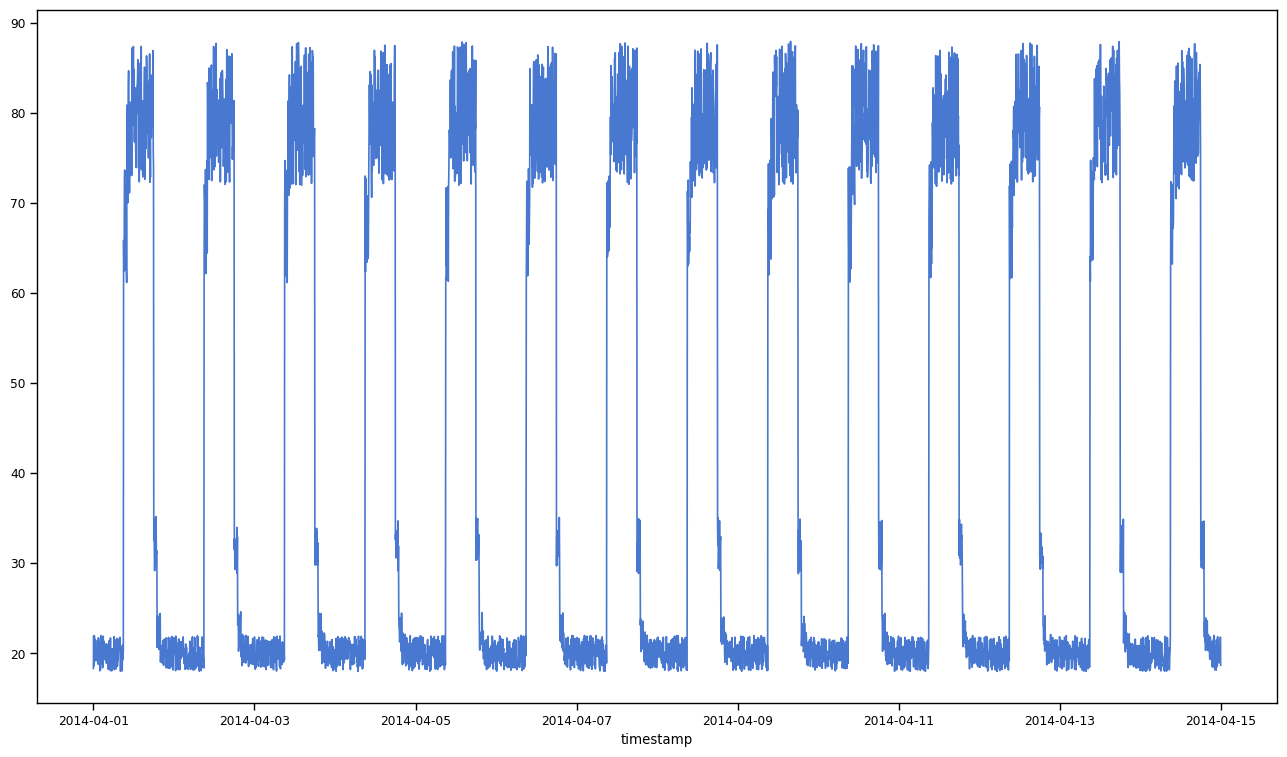

In [41]:
# Set colour palette
sns.set_palette("muted")
# Set style and figure size
sns.set_context("paper", font_scale=1)
fig, ax = plt.subplots(figsize=(16,9))

# Plot the data
sns.lineplot(data=df_small_noise, legend=False)
plt.show()

### Timeseries data with anomalies

Use the following data for testing and see if the data point that's out of range is detected as an anomaly

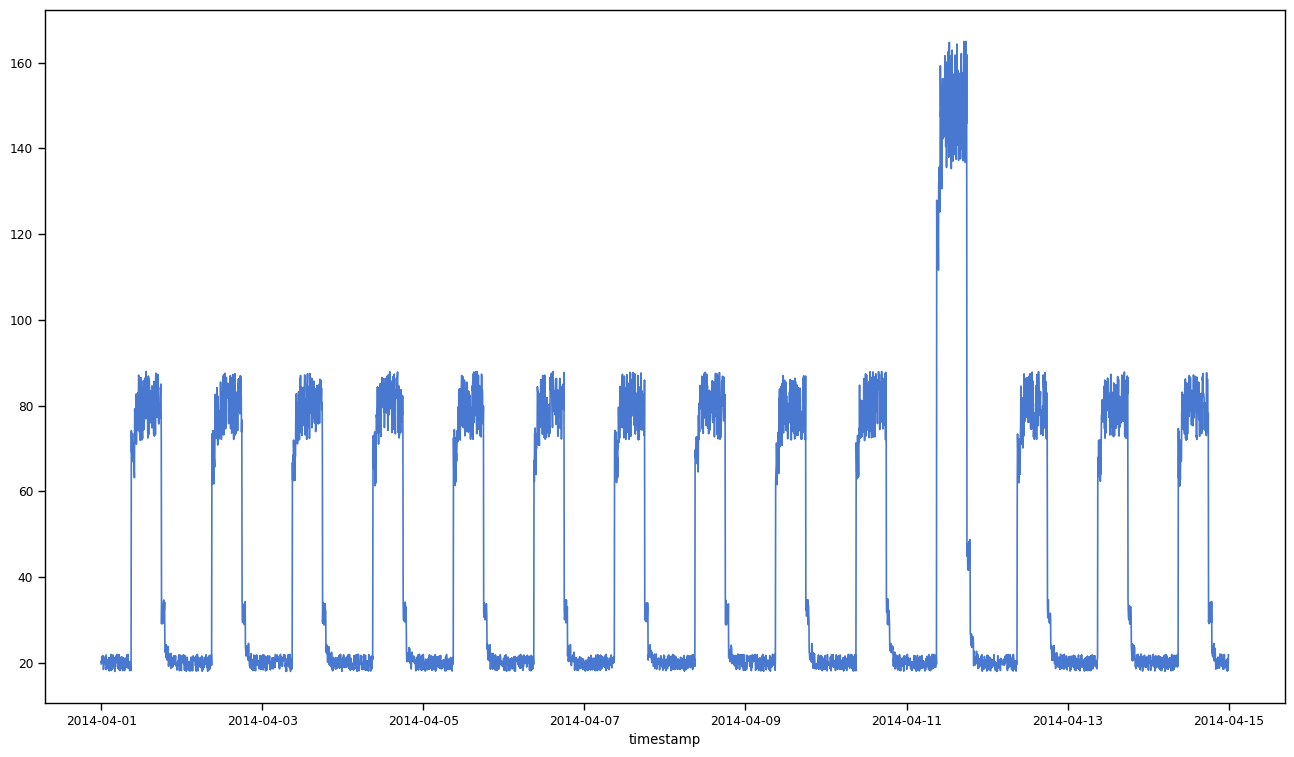

In [42]:
# Set colour palette
sns.set_palette("muted")
# Set style and figure size
sns.set_context("paper", font_scale=1)
fig, ax = plt.subplots(figsize=(16,9))

# Plot the data
sns.lineplot(data=df_daily_jumpsup, legend=False)
plt.show()

So it can be seen that there is indeed an anomaly.<br>
The next stage is to prepare the training data to train the autoencoder.

## Prepare the training data

At this stage, the data has to be prepared so that the model can 'learn' from it and detect anomalies.<br>
This is also known as preprocessing.<br>

Preprocessing is the stage where the data is checked and in the format that is needed to train and produce machine learning models.<br>
The very first stages were done in the previous section where the the number of rows in each data file were checked to make sure that there was no missing values.<br>

First, the data has to be normalized before anything else is done.<br>
Normalizing the data changes the data to a common scale without changing the differences in the range of values.

Get data values from the training timeseries data, *normalize* the value data.<br>
The value data points are every 5 minutes for 14 days.
- 24 * 60 / 5 = **288 timesteps per day**
- 288 * 14 = **4032 total data points**

In [44]:
# Normalize and save the mean and std we get,
# for normalizing test data.

# Get the mean and std deviation of training data
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()

# Normalise
df_training_value = (df_small_noise - training_mean) / training_std

# Confirm that the number of samples are the same.
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


The above can be rewritten as below to add columns to the dataframe with:<br>
- original value - mean
- original value / standard deviation

This will allow the columns to be plotted if desired.

In [46]:
df_small_noise['less_mean'] = df_small_noise['value'] - df_small_noise['value'].mean()
df_small_noise['div_std'] = df_small_noise['less_mean'] / df_small_noise['value'].std()
df_small_noise

,value,less_mean,div_std
timestamp,,,
2014-04-01 00:00:00,18.324919,-24.113435,-0.858829
2014-04-01 00:05:00,21.970327,-20.468026,-0.728993
2014-04-01 00:10:00,18.624806,-23.813547,-0.848148
2014-04-01 00:15:00,21.953684,-20.484669,-0.729586
2014-04-01 00:20:00,21.909120,-20.529234,-0.731173
...,...,...,...
2014-04-14 23:35:00,20.211195,-22.227159,-0.791647
2014-04-14 23:40:00,20.531041,-21.907313,-0.780255
2014-04-14 23:45:00,19.032127,-23.406226,-0.833640


In [47]:
# Get the mean of each column
df_small_noise['value'].mean(), df_small_noise['less_mean'].mean(), df_small_noise['div_std'].mean()

(42.438353335806646, -7.342627387941552e-14, -2.616541242931684e-15)

In [ ]:
# Get the standard deviation of each column
df_small_noise['value'].std(), df_small_noise['less_mean'].std(), df_small_noise['div_std'].std()

Plot the new columns below to confirm whether the normalisation. Compare with original data.

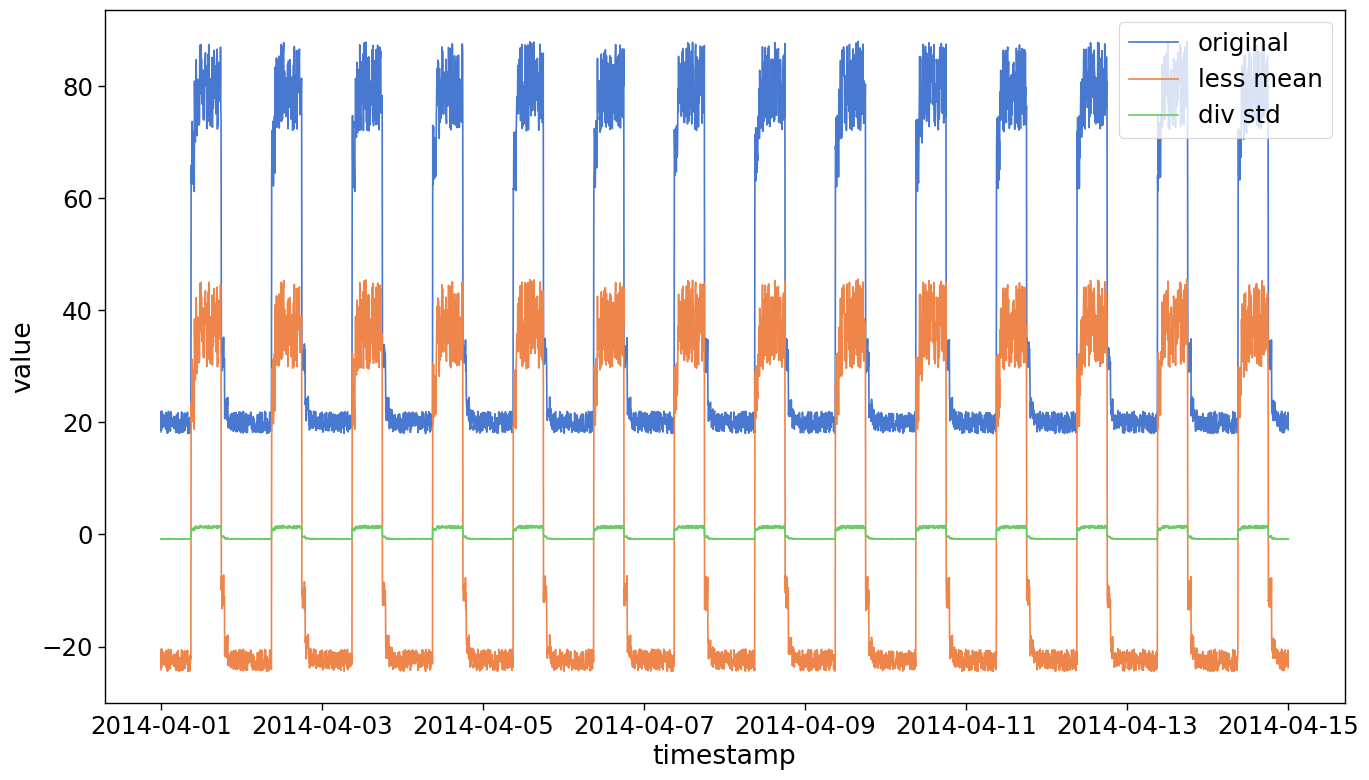

In [62]:
sns.set_palette("muted")
sns.set_context("paper", font_scale=2)
plt.figure(figsize=(16,9))
#sns.linplot(df_small_noise['value'],color='blue', bins=50, kde=True)
sns.lineplot(data=df_small_noise['value'], label='original')
sns.lineplot(data=df_small_noise['less_mean'], label='less mean')
sns.lineplot(data=df_small_noise['div_std'], label='div std')
plt.show()

### Create sequences

Create sequences combining TIME_STEPS contiguous data values from the training data:

In [7]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


## Build a model

The next step is to build a model - the convolutional reconstruction autoencoder model.<br>
The model will take input of shape:<br>
<span style="color:red">batch_size</span><br>
<span style="color:red">sequence_length</span><br>
<span style="color:red">num_features</span><br>
and return an output of the same shape.

From the created sequence above:<br>
<span style="color:red">sequence_length</span> = 288<br>
and<br>
<span style="color:red">num_features</span> = 1

What's happening in the cell below:

**Conv1D** is a 1-dimensional convolutional layer.
A convolutional layer is another way of saying 'A window that slides over the data we have'.
In this case, because it's time series data, the window is sliding along in one dimension (time).

In a 2-dimensional convolutional layer, the window is sliding along 2 dimensions, x and y.



In [8]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

## Train the model

Because this is a reconstruction model, <span style="color:red">x_train</span> will be used as both the input and target.

In [9]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 1s 26ms/step - loss: 0.5066 - val_loss: 0.0736
Epoch 2/50
27/27 [==============================] - 0s 15ms/step - loss: 0.0810 - val_loss: 0.0423
Epoch 3/50
27/27 [==============================] - 0s 14ms/step - loss: 0.0585 - val_loss: 0.0365
Epoch 4/50
27/27 [==============================] - 0s 15ms/step - loss: 0.0504 - val_loss: 0.0330
Epoch 5/50
27/27 [==============================] - 0s 15ms/step - loss: 0.0446 - val_loss: 0.0305
Epoch 6/50
27/27 [==============================] - 0s 17ms/step - loss: 0.0400 - val_loss: 0.0298
Epoch 7/50
27/27 [==============================] - 0s 16ms/step - loss: 0.0361 - val_loss: 0.0287
Epoch 8/50
27/27 [==============================] - 0s 14ms/step - loss: 0.0332 - val_loss: 0.0302
Epoch 9/50
27/27 [==============================] - 0s 14ms/step - loss: 0.0309 - val_loss: 0.0289
Epoch 10/50
27/27 [==============================] - 0s 15ms/step - loss: 0.0290 - val_loss: 0.0294
Epoch 11/

### Epoch Definition

From the results above, the phrase *Epoch* is used.

Machine learning models are trained by passing datasets through algorithms.
The phrase *Epoch* is used to describe an entire dataset being passed through an algorithm once.

An Epoch is also known as a *hyperparameter*.

### Training and validation loss

Now plot the training and validation loss to check the training:

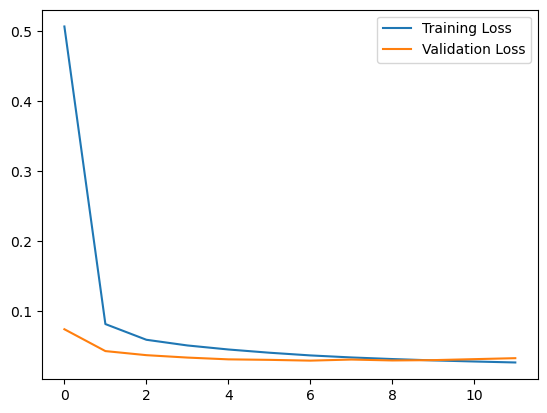

In [10]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Anomaly detection

Now find the anomalies by using the model to reconstruct the input data.<br>
The maximum MAE loss value will be the threshold for anomaly detection as it's the lowest performance the model has achieved whilst attempting to reconstruct a sample.

The following steps can be taken for detecting anomalies:
1. Find MAE (Mean Absolute Error) loss on training samples.
2. Find the maximum MAE loss value - this will be the <span style="color:red">threshold</span> value.
3. If the reconstruction loss for a data sample is greater than the <span style="color:red">threshold</span> value, it can be inferred that the model is observing an unfamiliar pattern - this will be labelled as an <span style="color:red">anomaly</span>.

118/118 [==============================] - 0s 2ms/step


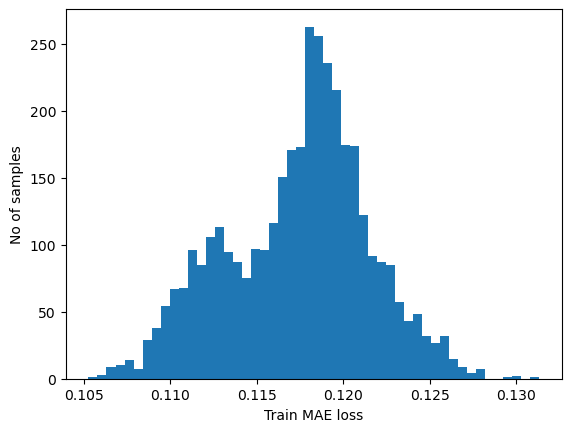

Reconstruction error threshold:  0.13132652923413607


In [11]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Compare reconstructed data with training data

We can compare the data sample that the model has generated for the first day with the training data for the first day - this is 288 timesteps

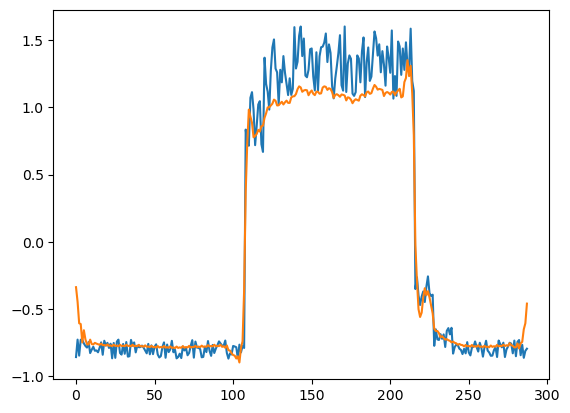

In [12]:
# Checking the first day's data sample with the original
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

### Prepare test data for the model

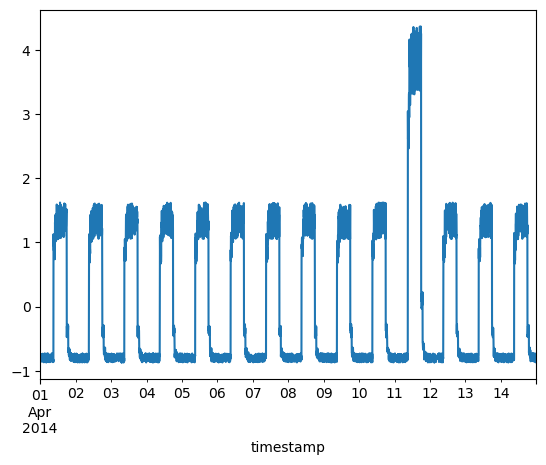

Test input shape:  (3745, 288, 1)
118/118 [==============================] - 0s 2ms/step


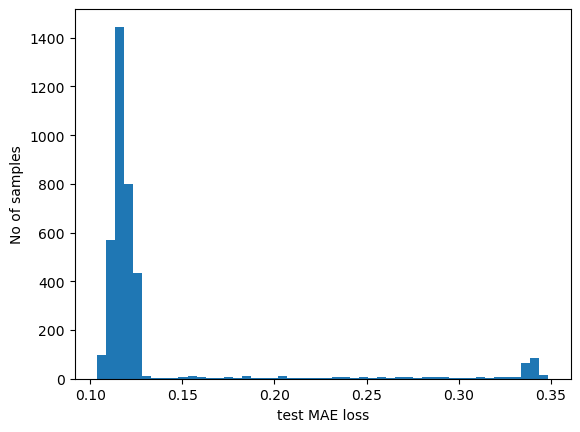

Number of anomaly samples:  394
Indices of anomaly samples:  (array([1654, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711,
       2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722,
       2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733,
       2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744,
       2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755,
       2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766,
       2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777,
       2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788,
       2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799,
       2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810,
       2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821,
       2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832,
       2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2

In [13]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

## Plot anomalies

The constructed data has shown us which data samples are anomalies, so we can plot the anomalies by using the corresponding timestamps of the training (original) data.<br>

This is the method:
If time_steps = 3 and there's 10 training values, <span style="color:red">x_train</span> will look like:<br>
- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9
<br>

All the values except the initial and the final time step values (<span style="color:red">TIME_STEPS </span>- 1) will appear in the <span style="color:red">time_steps </span>number of samples.<br>
So, if we know that the following samples:<br>

[(3, 4, 5), (4, 5, 6), (5, 6, 7)]<br>

are anomalies, we can say that data point 5 is an anomaly.

In [14]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

Overlay the anomalies on the original test plot.

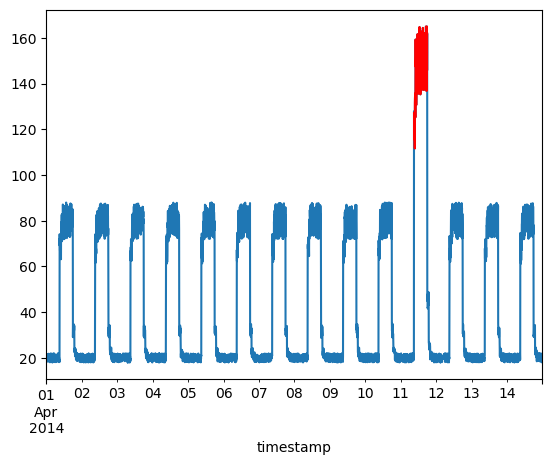

In [15]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

## Terminology

See below for deeper explanations about the terminology that's commonly used in machine learning.

### Deep Learning

Deep learning is a subset of machine learning that uses artificial neural networks to learn and find patterns in large amounts of data. IBM defines it as a neural network with three or more layers.<br>
Deep learning can work with unstructured and unlabelled data.

### Artificial neural networks

These are algorithms inspired by biological neural networks. Consisting of nodes and weights that are connected, where the nodes are also known as neurons.
Input signals are passed into the nodes, run through a function and multiplied by a weight to produce the final result - an output signal.

### Loss

Measures how good the deep learning model is.<br>
The loss value is the summation of errors in the model and a loss or cost function is used to calculate it.<br>
A high loss value means that model is producing lots of errors, and vice versa for a low loss value.

### Training loss

This is used to assess how well a deep learning model fits the training data presented to it. The training data is a part of the dataset used to train the model.
The training loss is calculated by taking the sum of errors for each point in the training data and is measured after each batch.

### Validation loss

This is used to assess how well the deep learning model performs on the validation data, where the validation data is a part of the dataset used to validate the model's performance.
Validation loss is also calculated from the sum of errors, but for each point in the validation set.

### Mean Absolute Error (MAE)

This is also known as L1 loss and is used for quantifying the quality of a machine learning model.
This is how we get to MAE.
1. Find the Prediction Error:<br> 
    Prediction Error = Actual Value - Predicted Value<br>
2. Get the Absolute Error:<br>
    Absolute Error = |Prediction Error|
3. MAE = average of absolute errors.

### Conclusion

### References


1. [Timeseries anomaly detection from Keras](https://keras.io/examples/timeseries/timeseries_anomaly_detection/)
2. [Numenta Anomaly Benchmark (NAB)](https://www.kaggle.com/datasets/boltzmannbrain/nab)
3. [Explanation of Time Series from Wikipedia](https://en.wikipedia.org/wiki/Time_series)
4. [Explanation of anomaly detection from IBM developer portal](https://developer.ibm.com/learningpaths/get-started-anomaly-detection-api/what-is-anomaly-detection/)
5. [Contextual anomaly detection](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-014-0011-y)
6. [Explanation of an autoencoder from Wikipedia](https://en.wikipedia.org/wiki/Autoencoder)
7. [IBM's definition of deep learning](https://www.ibm.com/cloud/learn/deep-learning)
8. [Explanation of Normalization from Wikipedia](https://en.wikipedia.org/wiki/Normalization_(statistics)#:~:text=In%20another%20usage%20in%20statistics%2C%20normalization%20refers%20to,gross%20influences%2C%20as%20in%20an%20anomaly%20time%20series.)
9. [Why Data Normalization is necessary for Machine Learning](https://medium.com/@urvashilluniya/why-data-normalization-is-necessary-for-machine-learning-models-681b65a05029)
10. [Keras Documentation for 1D Convolutional layer](https://keras.io/api/layers/convolution_layers/convolution1d/)<br>
11. [Introduction to autoencoders](https://www.tensorflow.org/tutorials/generative/autoencoder)<br>
12. [Definition of autoencoders from the Deep Learning book](https://www.deeplearningbook.org/contents/autoencoders.html)<br>
13. [Definition of variational autoencoders from wikipedia](https://en.wikipedia.org/wiki/Variational_autoencoder)<br>
14. [Colour styling in Seaborn](https://www.codecademy.com/article/seaborn-design-ii)<br>